In [ ]:
# -*-encoding :utf-8 -*-
 
import time
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

EPOCH = 1                           # 迭代次数
BATCH_SIZE = 50                     # 每一批训练的数据大小
LR = 0.001                          # 学习率
DOWNLOAD_MNIST = True               # 是否需要下载数据集，首次运行需要把该参数指定为True

'''
torchvisions 是一个数据集的库，下载torch的时候一起下载的
MNIST 是手写数字的数据集
root 是数据集的根目录
train为True 代表的是下载训练数据，为False代表下载的是测试数据
transform 是指定数据格式，ToTensor是将图片转化为0到1之间的Tensor类型的数据
download 表示是否需要下载数据集，如果已经下载过，就设置为False
'''
train_data = torchvision.datasets.MNIST(
    root='./',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=DOWNLOAD_MNIST
)

# # 查看数据size
# print(train_data.data.size())
# # 查看标签size
# print(train_data.targets.size())
# # 在画布上展示图片
# plt.imshow(train_data.data[0].numpy(), cmap='gray')
# # 设置标题，%i 代表转为有符号的十进制
# plt.title('%i'%train_data.targets[0])
# plt.show()

#  训练集分批
train_loader = Data.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# 下载测试集数据
test_data = torchvision.datasets.MNIST(
    root='./mnist',
    train=True,
)

'''
这里的test_data.data的size是(10000, 28, 28)
维度一 表示测试集总数
维度二 表示第多少个像素的横坐标对应的RGB值（这里已从三层(xxx,xxx,xxx)转为一层(k), k的值是0到1之间）
维度三 与参数二相似，表示的是纵坐标
添加维度(图片特征的高度)并切片后，test_x的size是(2000, 1, 28, 28)
PyTorch图层以Torch.FloatTensor作为输入，所以这里要指定一下torch.float32，否则在后续的训练中会报错。
最后除255是因为像素点是0-255范围的，这样可以做归一化处理，把特征值固定在0-1范围区间。如果不做
归一化处理，会在某些情况下（比如RNN神经网络）出现欠拟合的问题。
'''
test_x = torch.unsqueeze(test_data.data, dim=1).type(torch.FloatTensor)[:2000]/255
# 获取正确分类的结果
test_y = test_data.targets[:2000]


class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        '''
        对于nn.Conv2d中的padding参数，单独解释一下。
        把每个像素点当成一个特征，图像为28*28个像素，以长宽为5，步长为1的过滤器去扫描时，x轴方向，
        第一次扫描的是1~5个像素点（作为下一层神经网络的第1个特征），第二次扫描的是第2~6个像素点（作为下一层
        神经网络的第2个特征）……，最后一次扫描的是第24~28个像素点（作为下一层神经网络的第24个特征），会发现下一层
        比上一层少了4个特征。y轴方向也是同理。
        padding=2 表示在图像的四周都分别填充2个像素点。这样图像就变成了32*32个像素。
        此时按上述方式进行，会发现下一层的特征数量为28，这样就能保证两个神经网络层之间的特征数量相同。
        所以，想要 con2d 出来的图片长宽没有变化, padding=(kernel_size-stride)/2
        '''
        '''
        关于nn.MaxPool2d(kernel_size=2)
        把卷积后并经过激活函数的数据进行池化，MaxPooLing的方式池化（选取最大的一个像素点），
        池化的作用是压缩图片，筛选重要的特征信息。
        可以把它看成一个过滤器，kernel_size是过滤器的大小
        '''
        # 卷积层 主要是用做过滤
        self.conv1 = nn.Sequential(
            nn.Conv2d(            # 过滤器
                in_channels=1,    # 输入的高度，因为已经从RGB三层转为一层，所以这里是1
                out_channels=16,  # 过滤器的个数，也是输出的高度，每个过滤器收集一块图像区域的信息，作为一层图像高度信息
                kernel_size=5,    # 过滤器的大小(长宽)
                stride=1,         # 过滤器扫描时的步长
                padding=2         # 如果想要 con2d 出来的图片长宽没有变化, padding=(kernel_size-stride)/2
            ),
            nn.ReLU(),            # 激活函数
            nn.MaxPool2d(kernel_size=2)  # 池化，可以把它看成一个过滤器，kernel_size是过滤器的大小
        )
        self.conv2 = nn.Sequential(
            # 第一次卷积后，输出的高度为16，所以这里输入的高度是16
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        '''
        把经过两次卷积和池化的信息输入给全连接神经层
        32 * 7 * 7分别代表图片的高度和长、宽，是输入特征，10是输出特征（全类别的概率分布）。
        原本的图片是28个像素，经过一次卷积，但是因为定义了padding，卷积后图片长宽没有改变。在经过池化时，由于
        kernel_size=2，也就是说从2*2的像素块中提取一个最大像素的特征，既单独观察x轴，是从两个像素中抽取了一个。
        单独观察y轴也是同理。所以经过第一次池化时，像素点从28*28变成了14*14。再经过第二次卷积和激活函数，
        像素点不变，经过第二次池化，像素点变成了7*7。
        '''
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)           # torch.Size([50, 32, 7, 7])
        x = x.view(x.size(0), -1)   # torch.Size([50, 1568])，保留batch、把高、长、宽拉平，变成一维数据，相当于每次批训练 50 张图片，每张图片1568个特征
        output = self.out(x)
        return output

# 创建cnn模型对象
cnn = CNN()
# 指定分类器
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
# 指定误差计算的方式，一般来说，回归问题使用均方差，分类问题使用交叉熵
loss_func = nn.CrossEntropyLoss()

start_time = time.time()

for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)
        b_y = Variable(y)

        output = cnn(x)                                             # 传入测试数据，得出预测值
        loss = loss_func(output, b_y)                               # 对比预测值与真实值，得出loss值
        optimizer.zero_grad()                                       # 优化器梯度归零
        loss.backward()                                             # 进行误差反向传递
        optimizer.step()                                            # 将参数更新值施加到 cnn 的 parameters 上

        if step % 50 == 0:
            test_output = cnn(test_x)                               # torch.Size([2000, 10])
            pred_y = torch.max(test_output, 1)[1]                   # torch.Size([2000])
            accuracy = (sum(pred_y == test_y)).numpy() / test_y.size(0)     # 算出识别精度
            print('Epoch：', epoch, '| train loss：%.4f' % loss.data.numpy(), '| test accuracy：%.2f' % accuracy)

# 使用训练好的模型，预测前十个数据，然后和真实值对比
test_output = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1]
print(pred_y, 'prediction number')
print(test_y[:10], 'real number')

print('耗时：', time.time() - start_time)

Using downloaded and verified file: ./MNIST\raw\train-images-idx3-ubyte.gz
Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw


0it [00:00, ?it/s]

Using downloaded and verified file: ./MNIST\raw\train-labels-idx1-ubyte.gz
Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw


In [ ]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

dtype = torch.FloatTensor

# Text-CNN Parameter
embedding_size = 2 # n-gram
sequence_length = 3
num_classes = 2  # 0 or 1
filter_sizes = [2, 2, 2] # n-gram window
num_filters = 3

# 3 words sentences (=sequence_length is 3)
sentences = ["i love you", "he loves me", "she likes baseball", "i hate you", "sorry for that", "this is awful"]
labels = [1, 1, 1, 0, 0, 0]  # 1 is good, 0 is not good.

word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
vocab_size = len(word_dict)

inputs = []
for sen in sentences:
    inputs.append(np.asarray([word_dict[n] for n in sen.split()]))

targets = []
for out in labels:
    targets.append(out) # To using Torch Softmax Loss function

input_batch = Variable(torch.LongTensor(inputs))
target_batch = Variable(torch.LongTensor(targets))


class TextCNN(nn.Module):
    def __init__(self):
        super(TextCNN, self).__init__()

        self.num_filters_total = num_filters * len(filter_sizes)
        self.W = nn.Parameter(torch.empty(vocab_size, embedding_size).uniform_(-1, 1)).type(dtype)
        self.Weight = nn.Parameter(torch.empty(self.num_filters_total, num_classes).uniform_(-1, 1)).type(dtype)
        self.Bias = nn.Parameter(0.1 * torch.ones([num_classes])).type(dtype)

    def forward(self, X):
        embedded_chars = self.W[X] # [batch_size, sequence_length, sequence_length]
        embedded_chars = embedded_chars.unsqueeze(1) # add channel(=1) [batch, channel(=1), sequence_length, embedding_size]

        pooled_outputs = []
        for filter_size in filter_sizes:
            # conv : [input_channel(=1), output_channel(=3), (filter_height, filter_width), bias_option]
            conv = nn.Conv2d(1, num_filters, (filter_size, embedding_size), bias=True)(embedded_chars)
            h = F.relu(conv)
            # mp : ((filter_height, filter_width))
            mp = nn.MaxPool2d((sequence_length - filter_size + 1, 1))
            # pooled : [batch_size(=6), output_height(=1), output_width(=1), output_channel(=3)]
            pooled = mp(h).permute(0, 3, 2, 1)
            pooled_outputs.append(pooled)

        h_pool = torch.cat(pooled_outputs, len(filter_sizes)) # [batch_size(=6), output_height(=1), output_width(=1), output_channel(=3) * 3]
        h_pool_flat = torch.reshape(h_pool, [-1, self.num_filters_total]) # [batch_size(=6), output_height * output_width * (output_channel * 3)]

        model = torch.mm(h_pool_flat, self.Weight) + self.Bias # [batch_size, num_classes]
        return model

model = TextCNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
for epoch in range(5000):
    optimizer.zero_grad()
    output = model(input_batch)

    # output : [batch_size, num_classes], target_batch : [batch_size] (LongTensor, not one-hot)
    loss = criterion(output, target_batch)
    if (epoch + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

# Test
test_text = 'sorry hate you'
tests = [np.asarray([word_dict[n] for n in test_text.split()])]
test_batch = Variable(torch.LongTensor(tests))

# Predict
predict = model(test_batch).data.max(1, keepdim=True)[1]
if predict[0][0] == 0:
    print(test_text,"is Bad Mean...")
else:
    print(test_text,"is Good Mean!!")

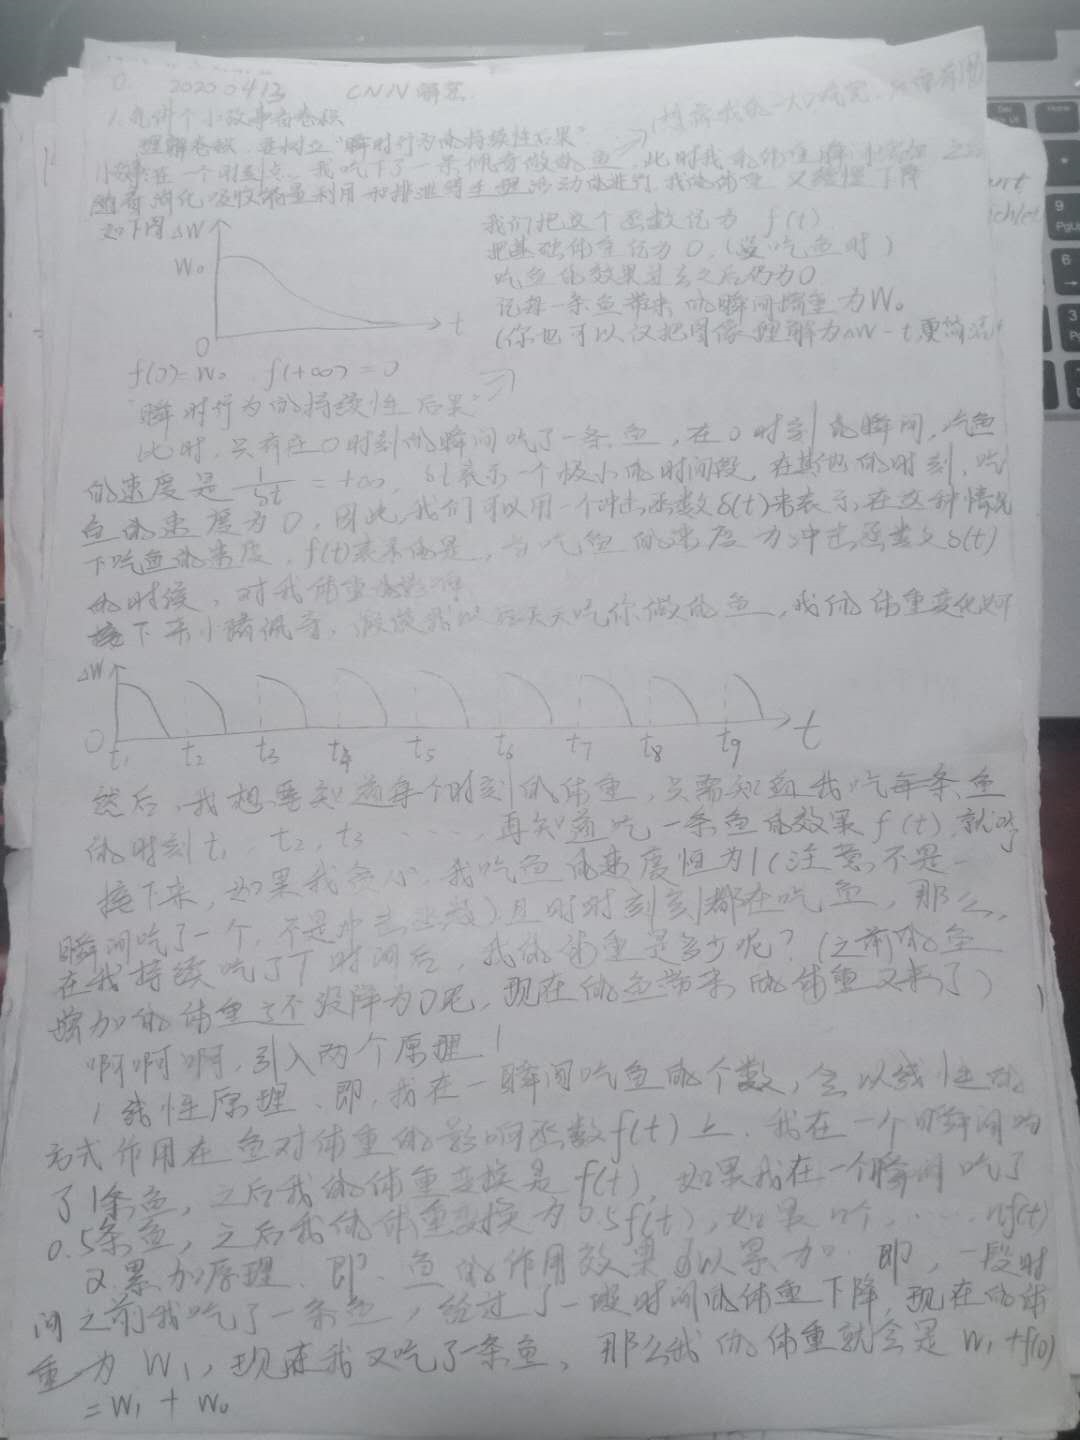

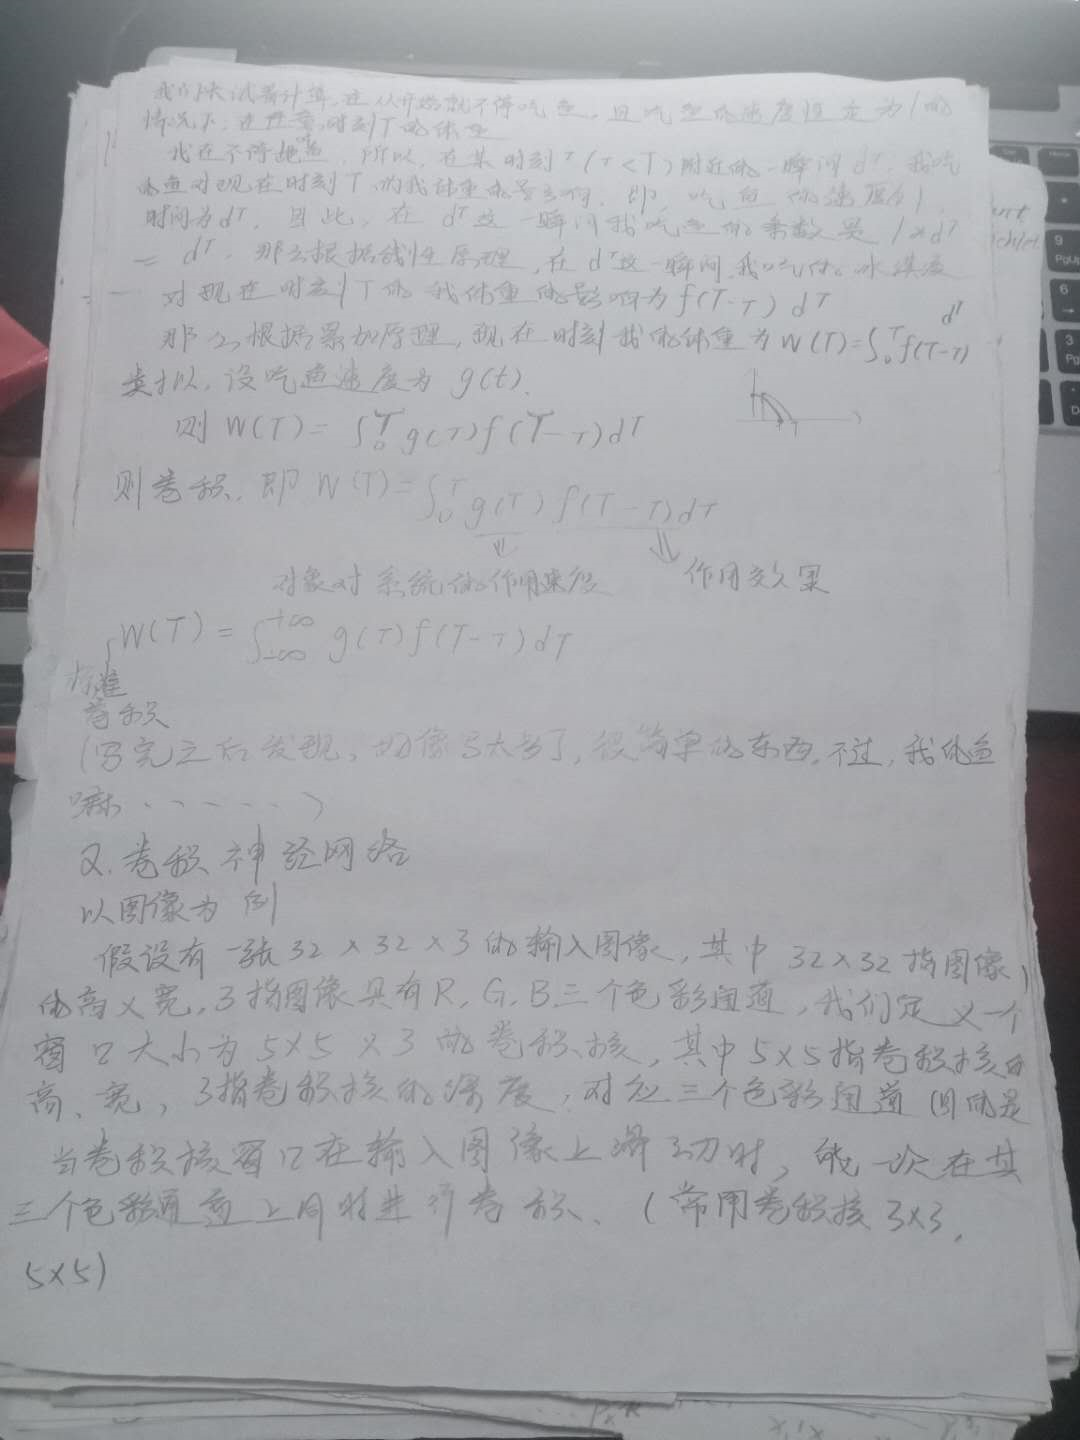

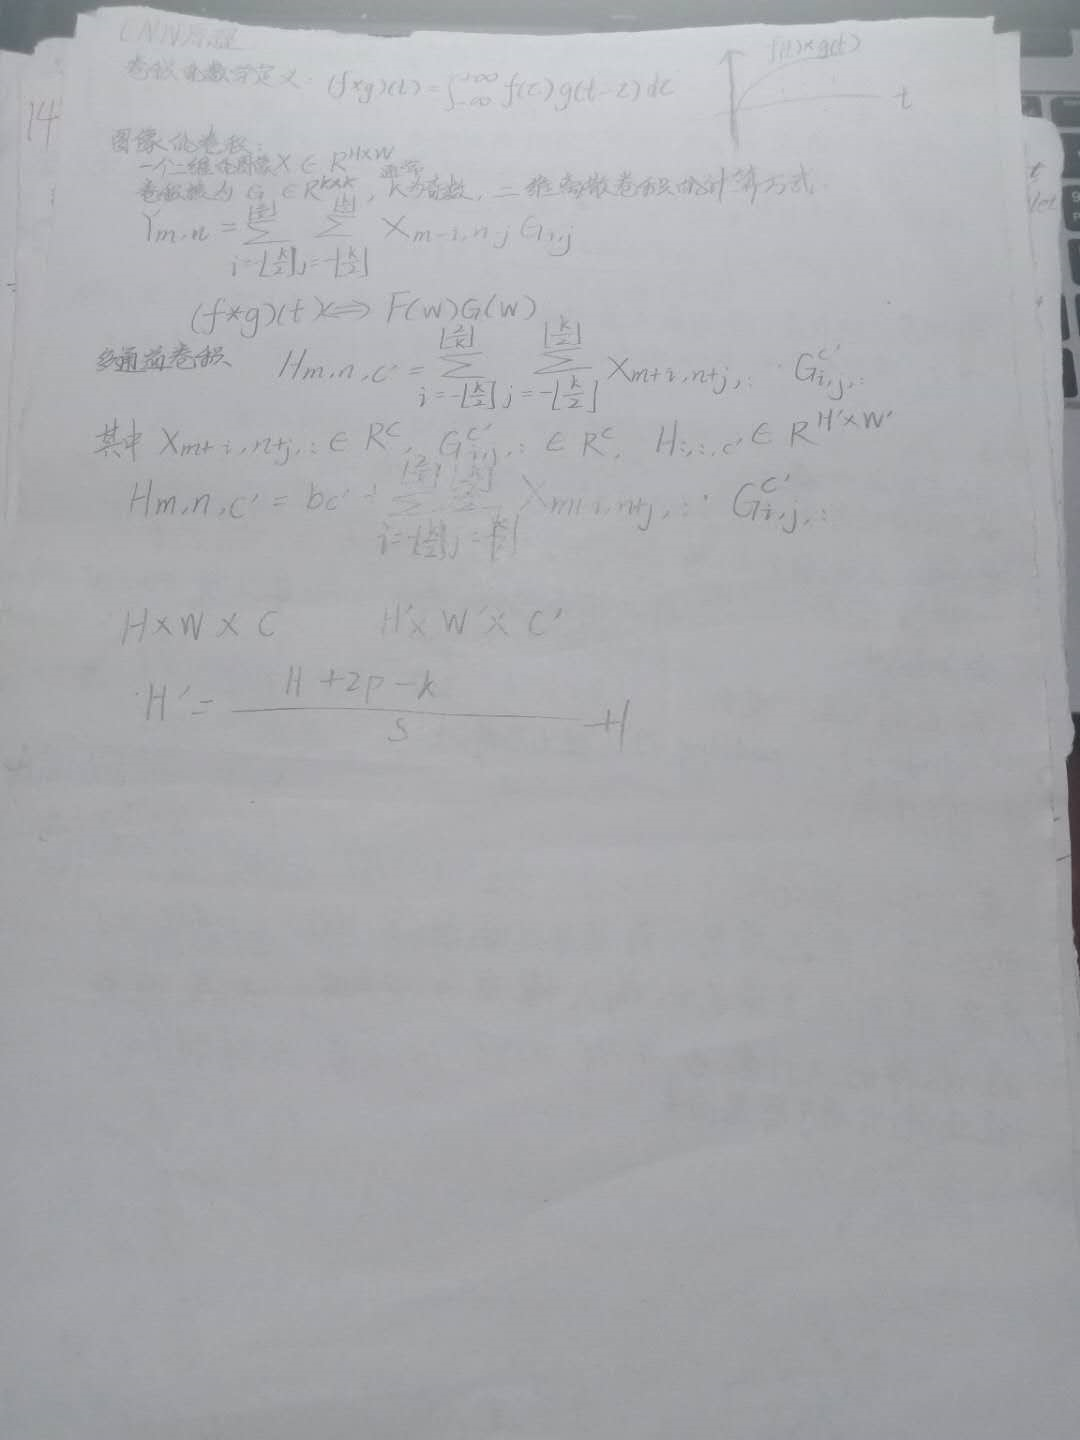

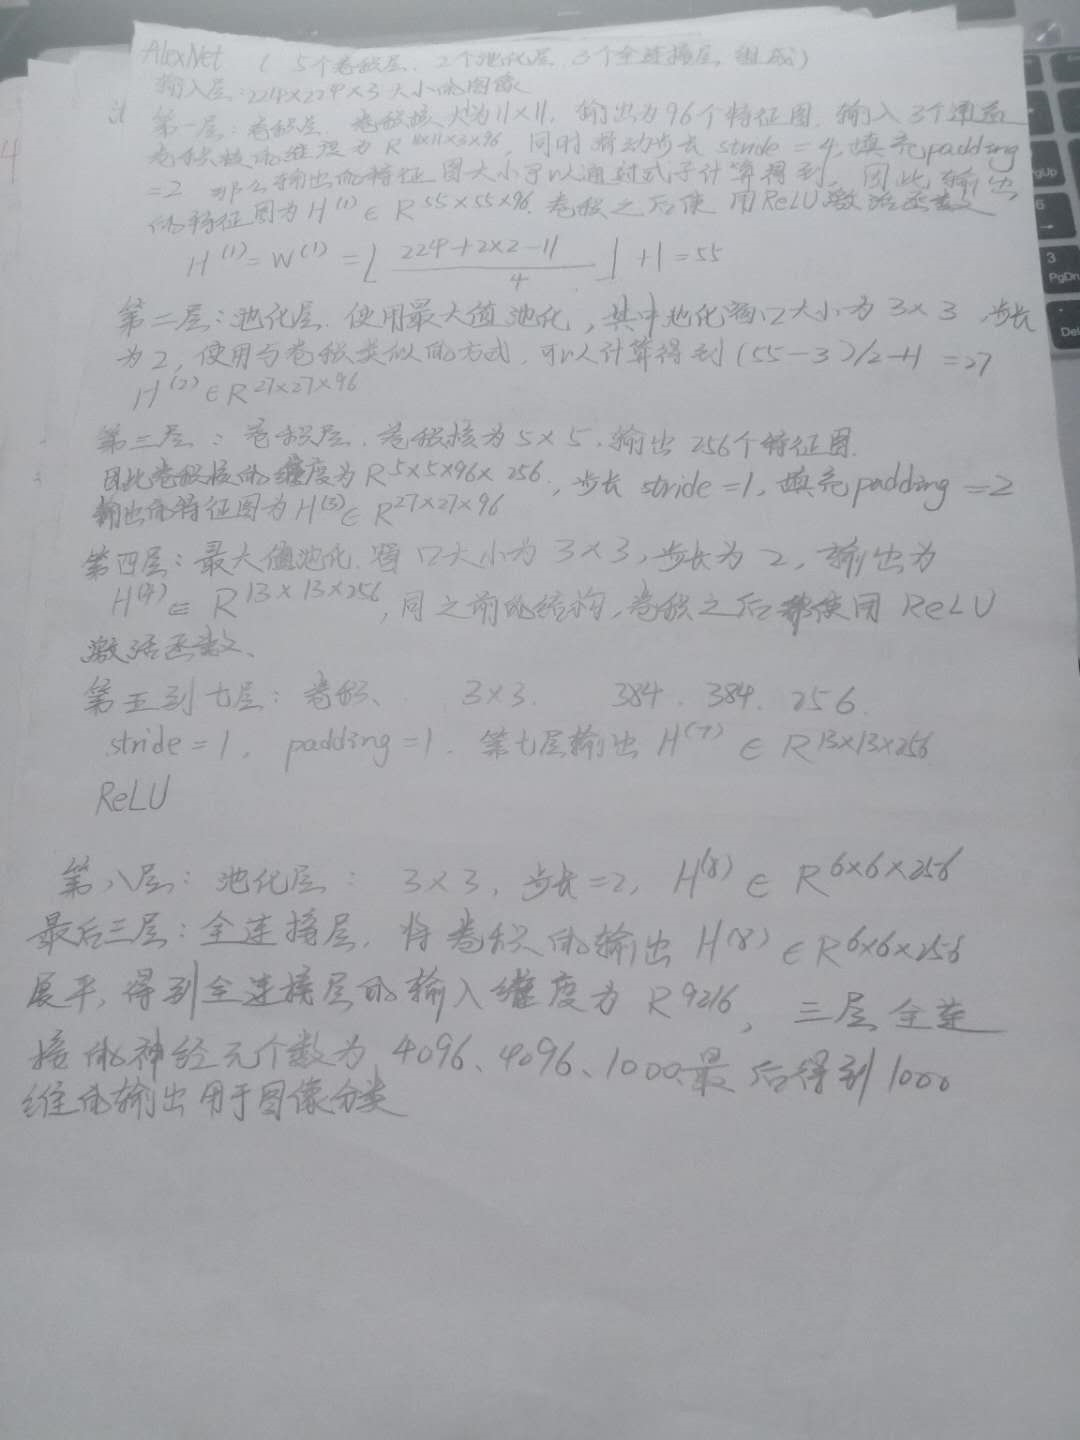

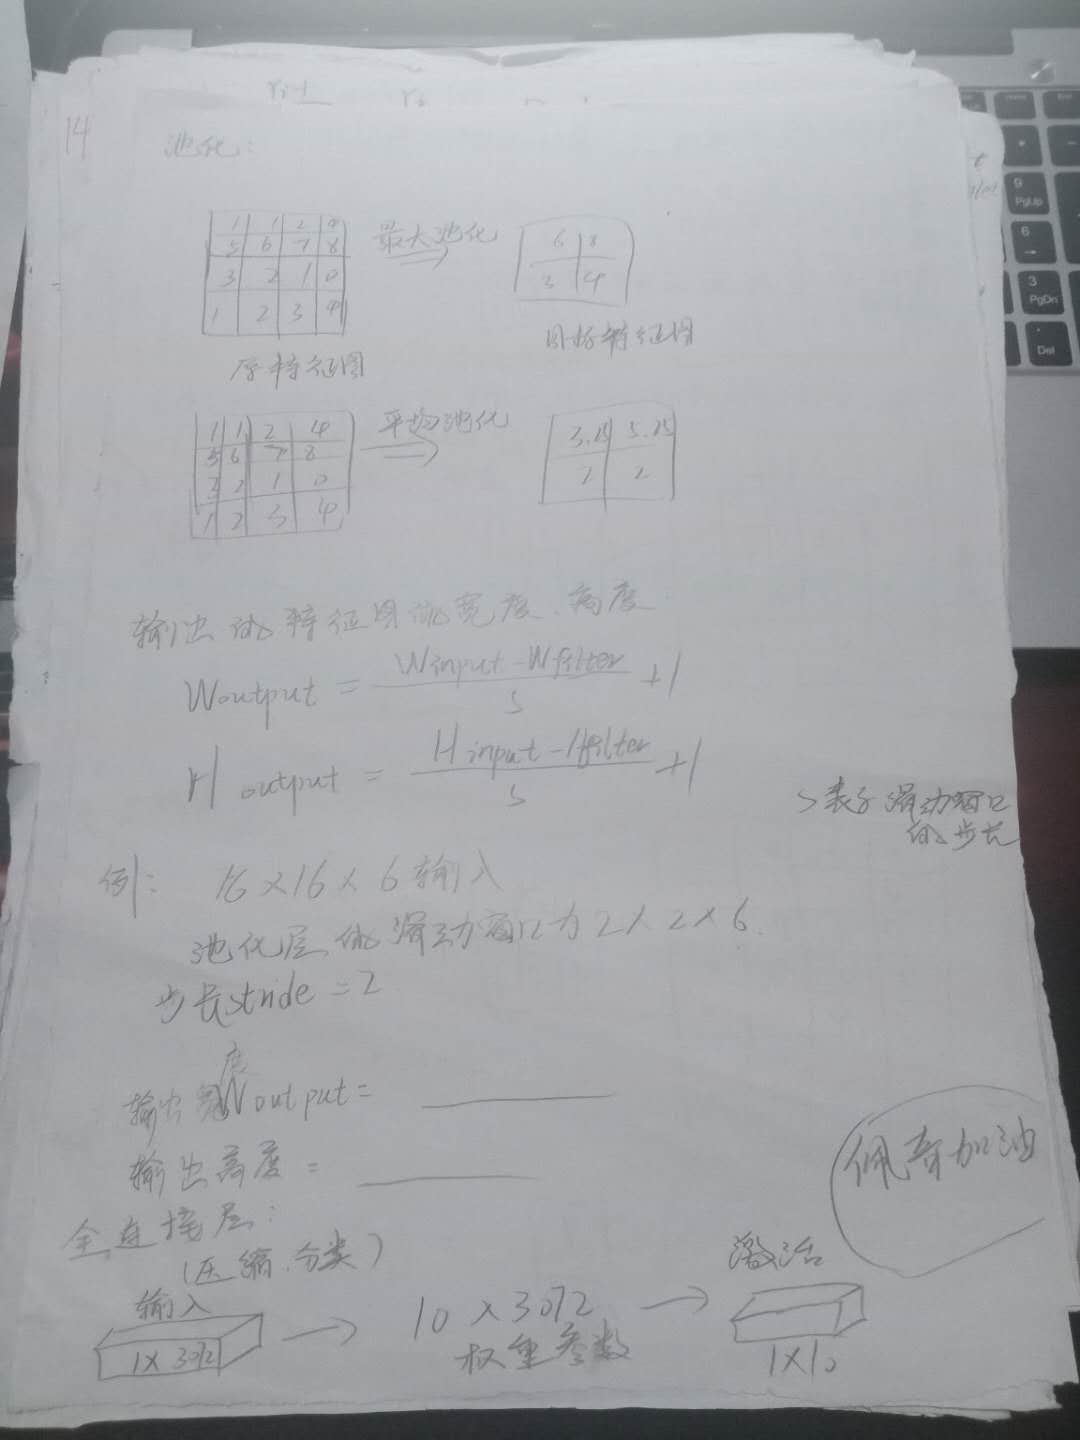

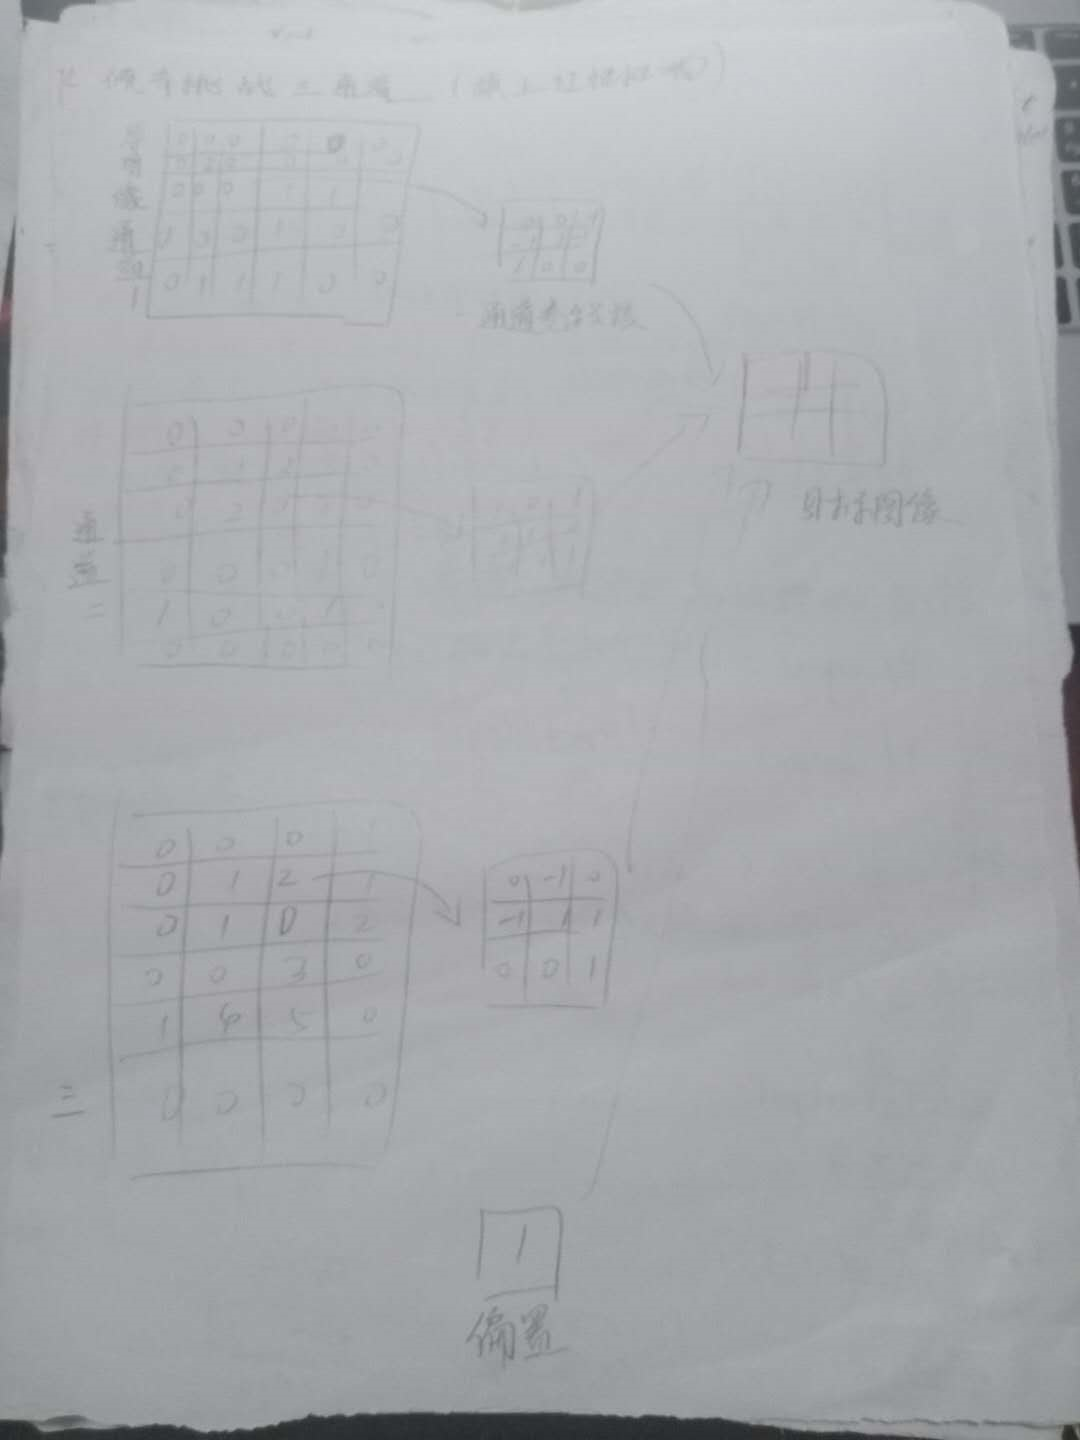

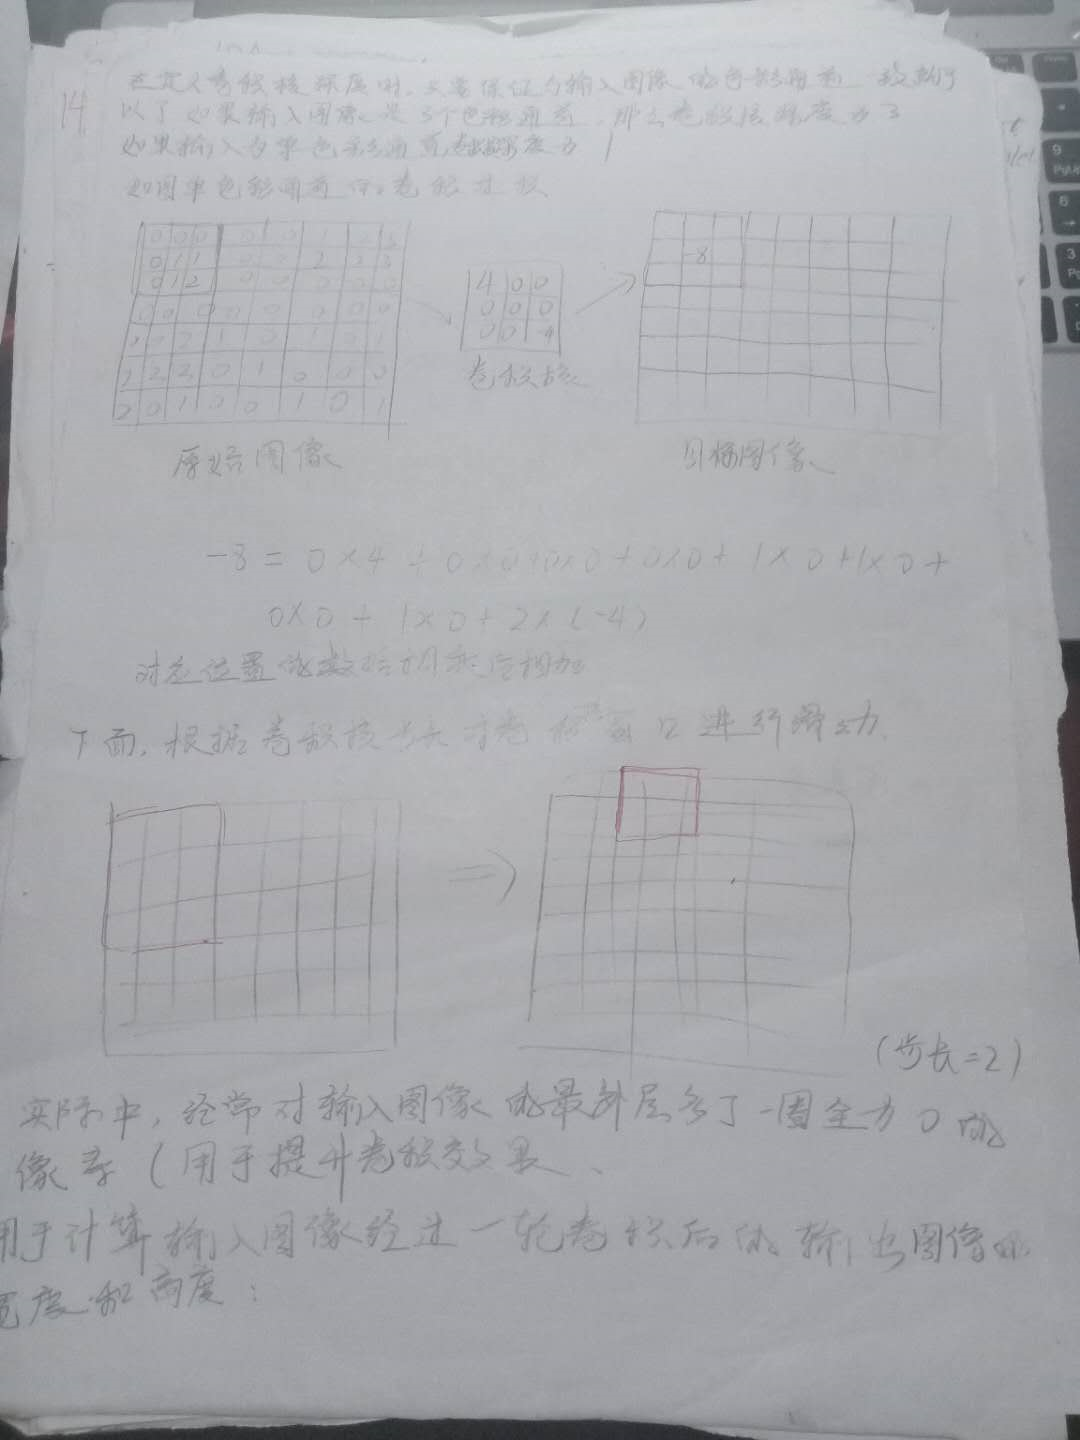

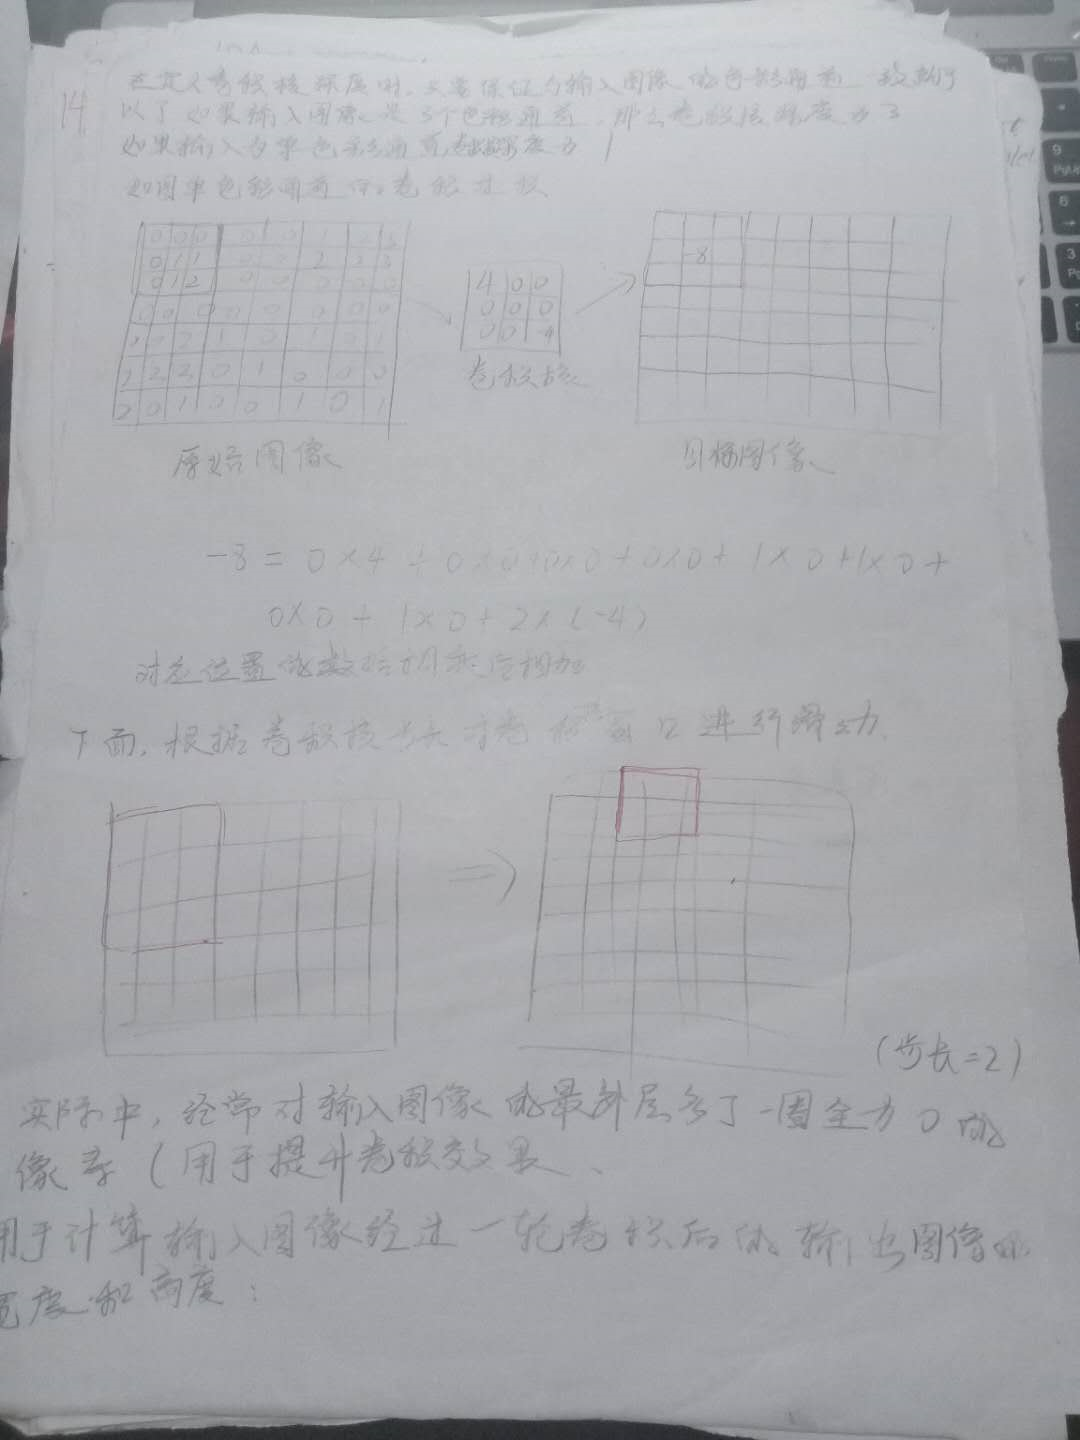

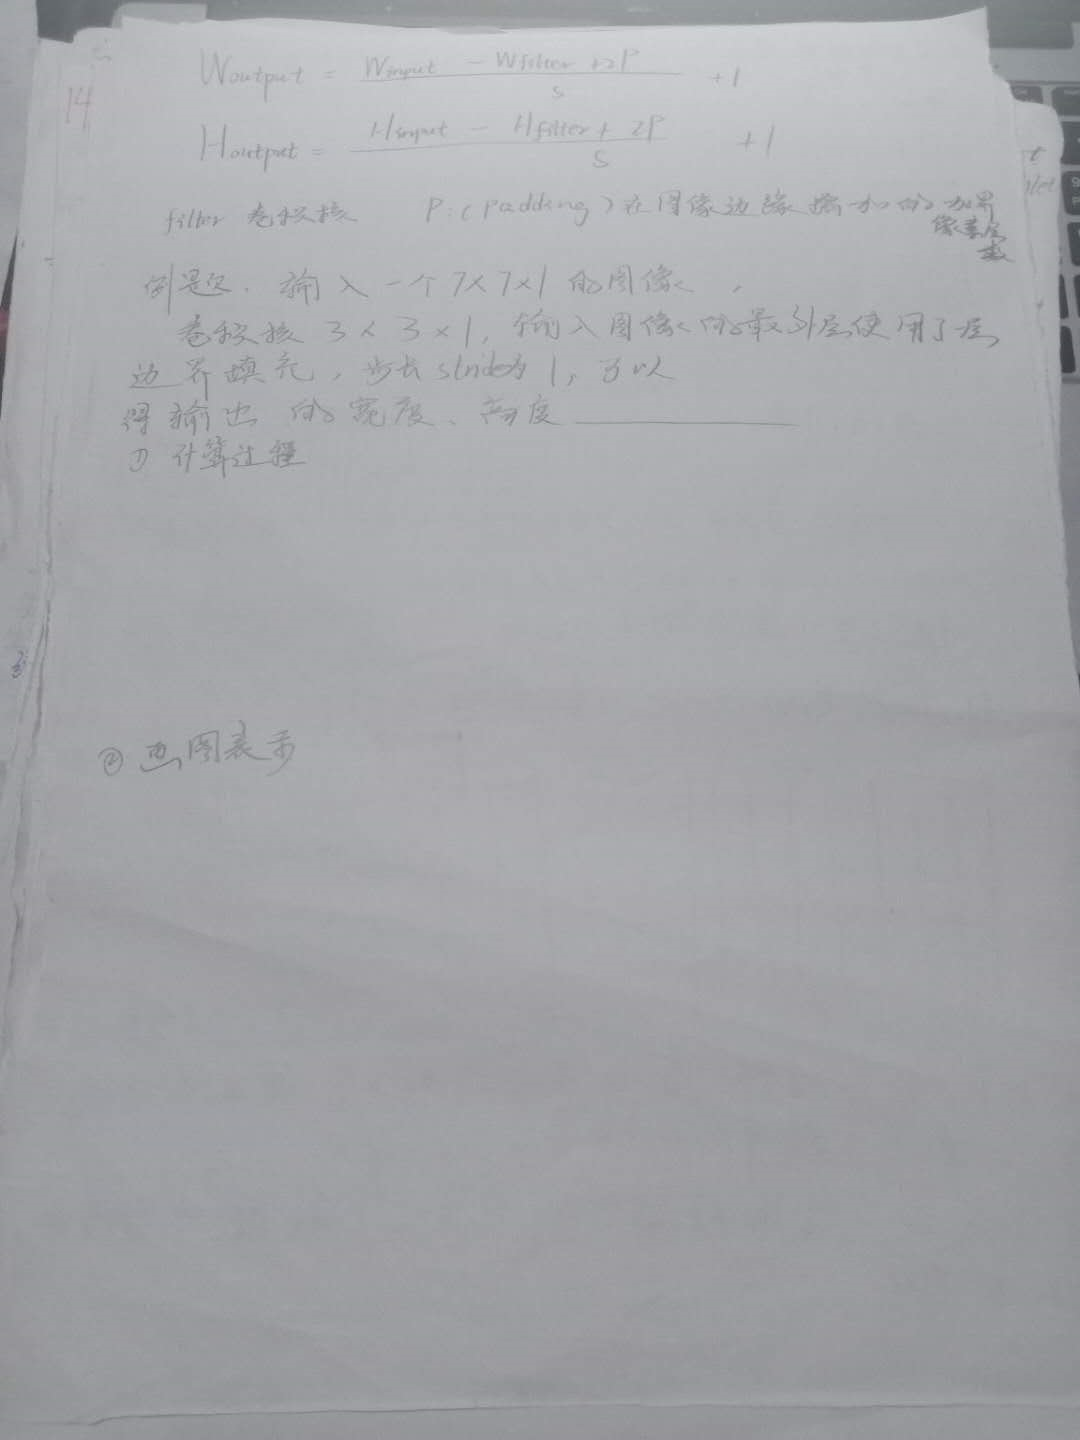

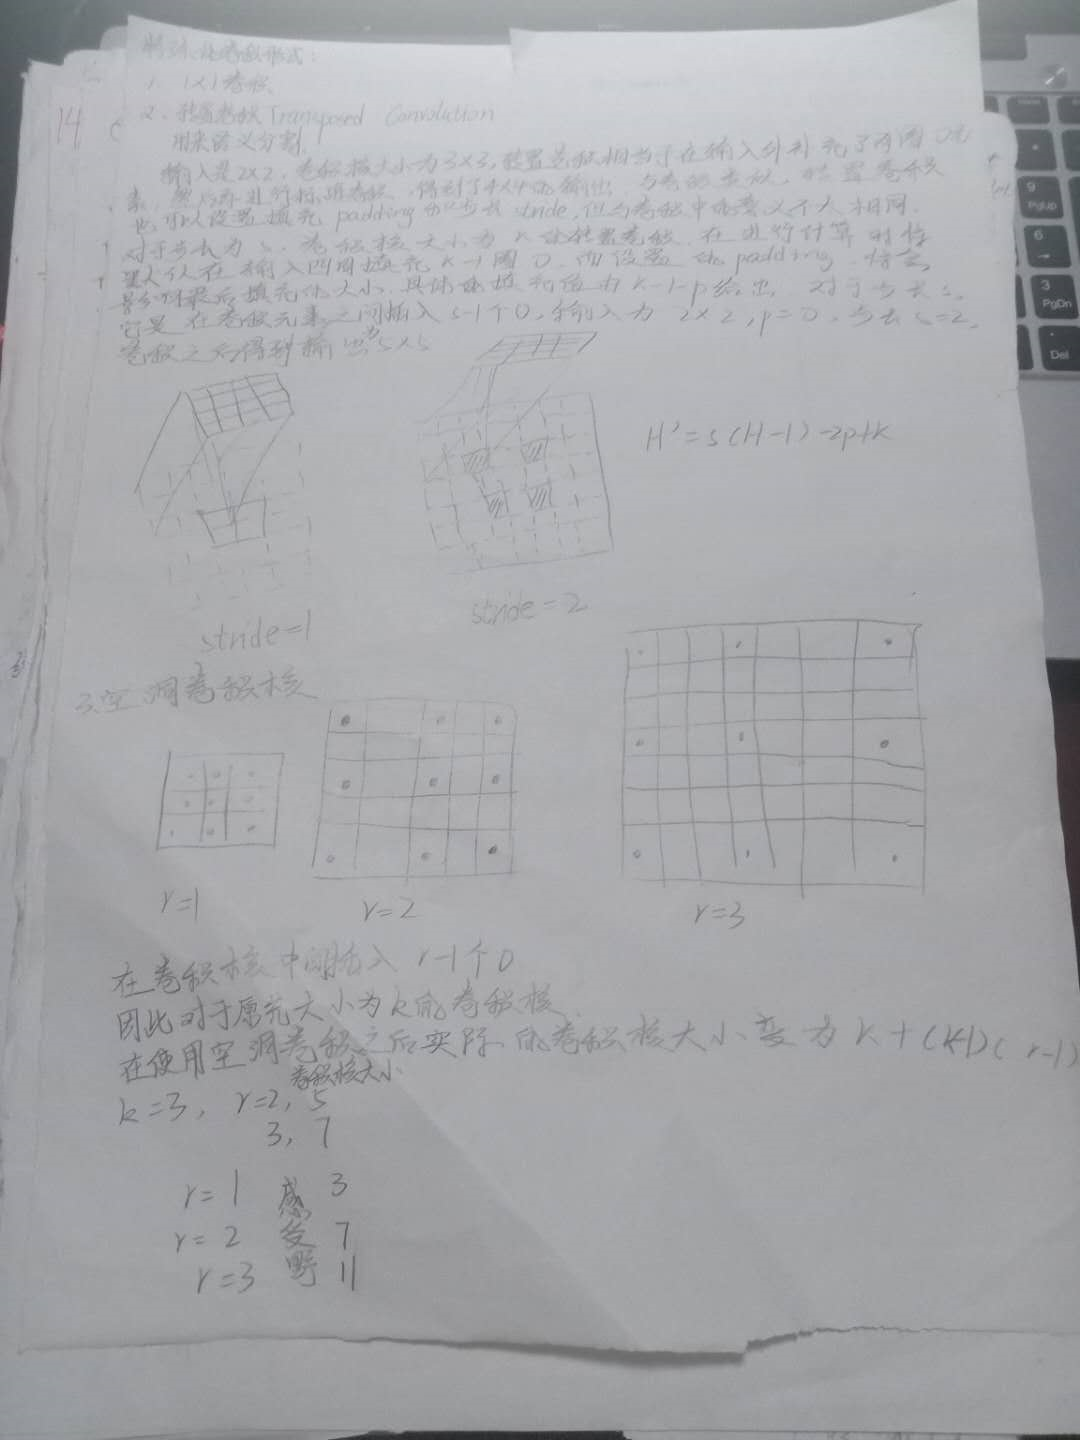

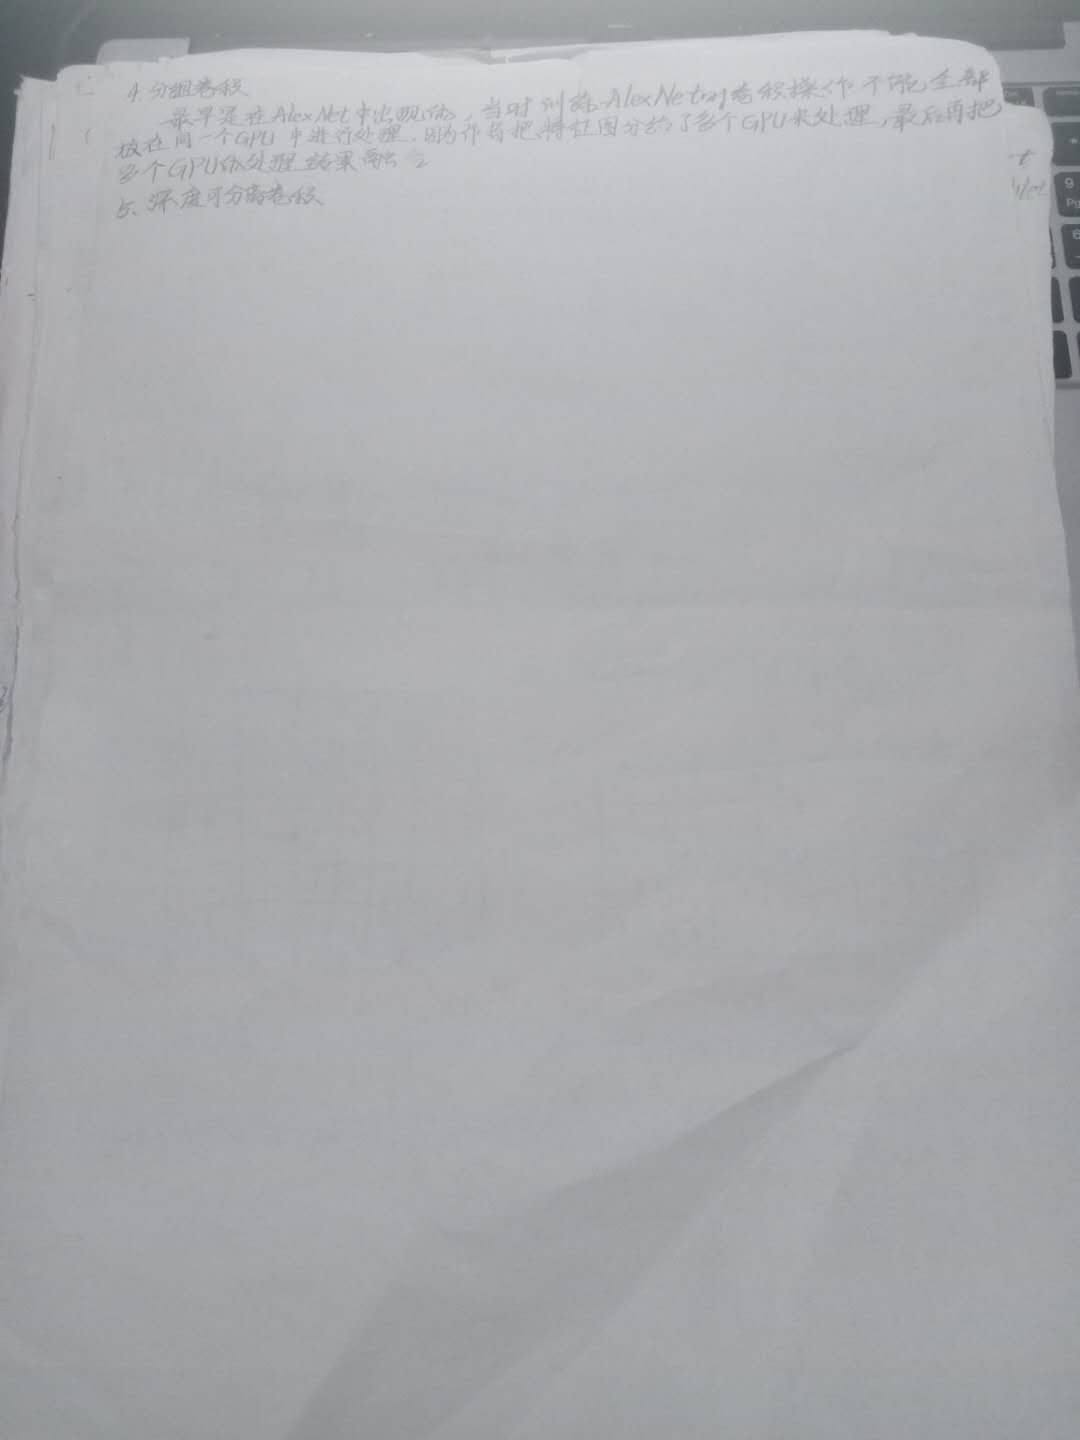